# Introduction to Spark
__Note__: this notebook should be launched under `pyspark` directed to IPython notebook as python interpreter (see https://spark.apache.org/docs/0.9.1/python-programming-guide.html).

In [2]:
%matplotlib inline
import pyspark

import matplotlib.pyplot as plt
import numpy as np
import scipy

import re

## A little bit of FP

Actually Python is not a good example of functional language

In [3]:
xs = range(5)

In [4]:
map(lambda x: x*x, xs)

[0, 1, 4, 9, 16]

In [5]:
reduce(lambda acc, x: acc  / (x + 1), xs, 1.0)

0.008333333333333333

In [6]:
filter(lambda x: x % 3 == 1, xs)

[1, 4]

## Basic RDD operations

### RDD creation

In [7]:
from pyspark import SparkContext

In [8]:
sc = SparkContext()

In [9]:
nums = sc.parallelize(xrange(0, 25)).persist()
text = sc.textFile("file:///root/notebook/Sherlock.txt").persist()

### Simple RDD operations

In [10]:
print nums.map(lambda x: x + 1).collect()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [11]:
words = text.flatMap(lambda x: re.findall("[a-zA-z']+", x)).map(lambda x: x.strip().lower()).persist()
words.take(10)

[u'project',
 u"gutenberg's",
 u'the',
 u'adventures',
 u'of',
 u'sherlock',
 u'holmes',
 u'by',
 u'arthur',
 u'conan']

In [12]:
print nums.filter(lambda x: x % 2 == 0).collect()

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]


In [13]:
print nums.flatMap(lambda x: [x] if x % 2 == 0 else []).collect()

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]


In [14]:
print nums.aggregate("", lambda acc, x: acc + str(x), lambda acc1, acc2: acc1 + " " + acc2)

 012  345  678  91011  121314  151617  181920  21222324 


In [15]:
print nums.repartition(1).aggregate("", lambda acc, x: acc + str(x), lambda acc1, acc2: acc1 + " " + acc2)

 0123456789101112131415161718192021222324 


In [16]:
print nums.fold(0, lambda a, b: a + b)

300


In [17]:
print nums.reduce(lambda a, b: a + b)

300


In [18]:
print nums.max(), nums.min()

24 0


### Pair RDD operations

In [19]:
words.map(lambda w: (w, 1)).groupByKey().map(lambda (w, c): (w, sum(list(c)))).take(10)

[(u'aided', 1),
 (u'hollowed', 1),
 (u'augustine', 1),
 (u'believed', 3),
 (u'hats', 1),
 (u'crumpled', 3),
 (u'yellow', 15),
 (u'four', 38),
 (u'grosvenor', 2),
 (u'sleep', 11)]

In [20]:
count = words.map(lambda w: (w, 1)).reduceByKey(lambda c1, c2: c1 + c2).persist()
count.take(20)

[(u'aided', 1),
 (u'hollowed', 1),
 (u'augustine', 1),
 (u'believed', 3),
 (u'hats', 1),
 (u'crumpled', 3),
 (u'yellow', 15),
 (u'four', 38),
 (u'grosvenor', 2),
 (u'sleep', 11),
 (u'keeper', 11),
 (u"friend's", 10),
 (u'scheming', 1),
 (u'pheasant', 1),
 (u'saved', 9),
 (u'swag', 1),
 (u'pointing', 7),
 (u'granting', 1),
 (u'paris', 1),
 (u'characterises', 1)]

### RDD to RDD operations

In [21]:
wordsLen = words.distinct().map(lambda w: (w, len(w))).persist()
wordsLen.take(10)

[(u'aided', 5),
 (u'hollowed', 8),
 (u'augustine', 9),
 (u'believed', 8),
 (u'hats', 4),
 (u'crumpled', 8),
 (u'yellow', 6),
 (u'four', 4),
 (u'grosvenor', 9),
 (u'sleep', 5)]

In [22]:
count.cogroup(wordsLen).map( lambda (w, (counts, lens)): (w, list(counts), list(lens)) ).take(10)

[(u'aided', [1], [5]),
 (u'four', [38], [4]),
 (u'sleep', [11], [5]),
 (u'mansion', [1], [7]),
 (u'pheasant', [1], [8]),
 (u'saved', [9], [5]),
 (u'kempt', [1], [5]),
 (u'paris', [1], [5]),
 (u'characterises', [1], [13]),
 (u'originality', [1], [11])]

In [23]:
count.join(wordsLen).take(10)

[(u'aided', (1, 5)),
 (u'four', (38, 4)),
 (u'sleep', (11, 5)),
 (u'mansion', (1, 7)),
 (u'pheasant', (1, 8)),
 (u'saved', (9, 5)),
 (u'kempt', (1, 5)),
 (u'paris', (1, 5)),
 (u'characterises', (1, 13)),
 (u'originality', (1, 11))]

## Word count 

In [24]:
wordCount = sc.textFile("file:///root/notebook/Sherlock.txt").flatMap(
    lambda x: re.findall("[a-zA-z']+", x)
).map(
    lambda x: x.strip().lower()
).map(
    lambda w: (w, 1l)
).reduceByKey(
    lambda c1, c2: c1 + c2
).persist()

### Find top N words
def top(N):
    def reducer(wc1, wc2):
        wc = wc1 + wc2
        return sorted(wc, key = lambda wc: -wc[1])[:N]
    return reducer

top10 = wordCount.map(lambda wc: [wc]).reduce(top(10))

for word, c in top10:
    print word, "\t" , c

the 	5796
and 	3069
i 	2961
to 	2820
of 	2778
a 	2697
in 	1821
that 	1751
it 	1705
you 	1520


### Zipf's law

<Container object of 250 artists>

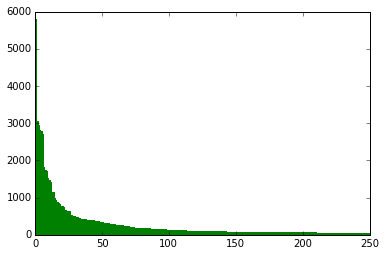

In [25]:
top250 = wordCount.map(lambda wc: [wc]).reduce(top(250))
plt.bar(range(250), sorted([ c for w, c in top250 ], reverse=True)[:250], color="green", edgecolor="green")

In [26]:
freqByLen = sorted (
    wordCount.map(
        lambda (w, c): (len(w), c)
    ).reduceByKey(
        lambda c1, c2: c1 + c2
    ).collect(),

    key = lambda (l, c): l
)

<Container object of 18 artists>

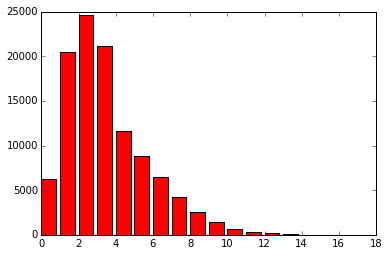

In [27]:
plt.bar(range(len(freqByLen)), [ c for (l, c) in freqByLen], color="red")

### Heap's law

In [28]:
uniqsByLen = list()
wordsN = words.count()
samples = 10
fractions = [ f for i in range(1, 101) for f in [i / 100.0]]

counts = list()
uniqs = list()
for fraction in fractions:
    sample = words.sample(withReplacement=False, fraction=fraction).persist()
    uniq = sample.countApproxDistinct()
    count = sample.count()
    uniqs.append(uniq)
    counts.append(count)
    sample.unpersist()

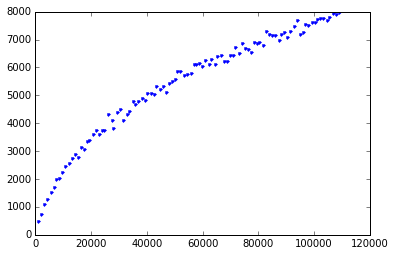

In [29]:
plt.figure()
plt.plot(counts, uniqs, ".")
plt.show()

# Spark MLlib

In [30]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD
import pandas as pd

### Load data

In [31]:
from math import isnan
from operator import or_

def parsePoints(df):
    data = list()
    for i in xrange(len(df)):
        survived = float(df["Survived"][i])
        age = float(df["Age"][i])
        pClass = float(df["Pclass"][i])
        nameL = float(len(df["Name"][i]))
        sex = 1.0 if df["Sex"][i] == "male" else 0.0
        sibSp = float(df["SibSp"][i])
        parch = float(df["Parch"][i])
        fare = float(df["Fare"][i])
        features = [age, pClass, nameL, sex, sibSp, parch, fare]
    
        if reduce(or_, map(isnan, features)):
            continue
        
        p = LabeledPoint(survived, features)
        data.append(p)
    return data

df = pd.read_csv("./train.csv")
data = parsePoints(df)
print "N:", len(data)
train, test = sc.parallelize(data).randomSplit([0.5, 0.5], seed=2l)

print "Train positive:", train.filter(lambda p: p.label == 1.0).count()
print "Train negative:", train.filter(lambda p: p.label == 0.0).count()

print "Test positive:", test.filter(lambda p: p.label == 1.0).count()
print "Test negative:", test.filter(lambda p: p.label == 0.0).count()

N: 714
Train positive: 140
Train negative: 189
Test positive: 150
Test negative: 235


### Logistic Regression

In [32]:
logisticM = LogisticRegressionWithSGD.train(train, 250)
logisticM

(weights=[-1.00213409366,-1.7844445772,0.30625711465,-2.23116982375,-1.85366804747,-1.14475229818,0.767416853271], intercept=0.0)

In [33]:
validation = test.map(
    lambda p: (int(round(p.label)), logisticM.predict(p.features))
).persist()

validation.take(10)

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (1, 0),
 (0, 1),
 (0, 0),
 (0, 0),
 (1, 0),
 (0, 1)]

In [34]:
total = float(validation.count())
tp = validation.filter(lambda (real, pred): real == 1 and pred == 1).count() / total
fp = validation.filter(lambda (real, pred): real == 0 and pred == 1).count() / total
tn = validation.filter(lambda (real, pred): real == 0 and pred == 0).count() / total
fn = validation.filter(lambda (real, pred): real == 1 and pred == 0).count() / total

print "tp:", "%.2f" % tp
print "fp:", "%.2f" % fp
print "tn:", "%.2f" % tn
print "fn:", "%.2f" % fn

tp: 0.19
fp: 0.12
tn: 0.49
fn: 0.20


In [35]:
def logistic(w):
    from math import exp
    def predict(x):
        z = w.dot(x)
        return 1 / (1 + exp(-z))
    return predict

predict_proba = logistic(logisticM.weights)
predicted_proba = test.map (
    lambda p: (p.label, predict_proba(p.features))
).collect()

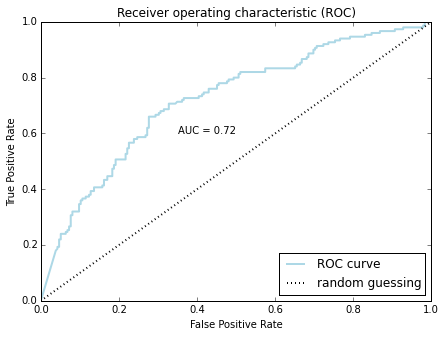

In [36]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve([ r for r, p in predicted_proba ], [ p for r, p in predicted_proba ])
roc_auc = auc(fpr, tpr)

# Plot ROC curve

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

plt.plot(fpr, tpr, color='lightblue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='dotted', label='random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
ax.annotate('AUC = %0.2f' %roc_auc, xy=(0.35, 0.6))
plt.show()

### Gradient Boosting (optional)

In [37]:
sc.version

u'1.3.0'

In [38]:
from pyspark.mllib.tree import GradientBoostedTrees

GBTModel = GradientBoostedTrees.trainRegressor(train, dict(), numIterations=20, maxDepth=3)
print GBTModel
testGBT = [ (p.label, GBTModel.predict(p.features)) for p in test.collect()]

TreeEnsembleModel regressor with 20 trees



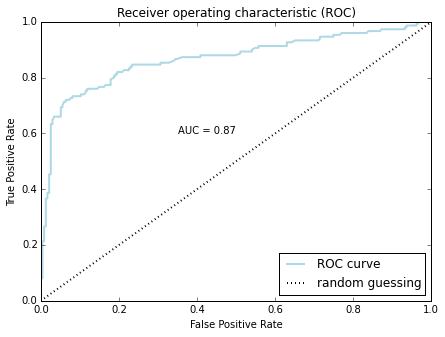

In [39]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve([ r for r, p in testGBT ], [ p for r, p in testGBT ])
roc_auc = auc(fpr, tpr)

# Plot ROC curve

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

plt.plot(fpr, tpr, color='lightblue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='dotted', label='random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
ax.annotate('AUC = %0.2f' %roc_auc, xy=(0.35, 0.6))
plt.show()